In [2]:
##HHL validate with the paper###

from qiskit import Aer, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_eigs(matrix, num_auxiliary, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_auxiliary += 1
        ne_qfts = [QFT(num_auxiliary - 1), QFT(num_auxiliary - 1).inverse()]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_auxiliary).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_auxiliary,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None,  # This is t, can set to: np.pi*3/4
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

In [3]:
def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    return fidelity

In [4]:
#https://www.sciencedirect.com/science/article/pii/S037596012030462X?via%3Dihub
# to solve for linear equation Ax=b and comparing results with the paper

matrix = [[1.5, 0.5], [0.5, 1.5]] #A 
vector = [0.707, 0.707]           #b


matrix=[[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1]]

vector = [0.707, 0.707, 0.707, 0.707]           #b

e,v=np.linalg.eig(matrix)

print('Matrix:\n',matrix)
print('Eigen Values:',e)
print('Condition Number:',max(e)/min(e))
#to find x using the HHL 

Matrix:
 [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
Eigen Values: [1. 1. 1. 1.]
Condition Number: 1.0


In [5]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)


circ=algo.construct_circuit(measurement=True)
#circ.draw(fold=-1)

In [6]:
result = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
print("Solution:\t\t", np.round(result['solution'], 5))

#print(result)

result_ref = NumPyLSsolver(matrix, vector).run()
print("Classical Solution:\t", np.round(result_ref['solution'], 5))

print("Probability:\t\t %f" % result['probability_result'])
fid=fidelity(result['solution'], result_ref['solution'])
print("Fidelity:\t\t %f\n" % fid)

Solution:		 [0.707-0.j 0.707-0.j 0.707-0.j 0.707-0.j]
Classical Solution:	 [0.707 0.707 0.707 0.707]
Probability:		 0.020408
Fidelity:		 1.000000



In [7]:
def get_hhl_fidelity(matrix,vector,condition_num):
    orig_size = len(vector)
    matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

    # Initialize eigenvalue finding module
    eigs = create_eigs(matrix, 3, 50, False)
    num_q, num_a = eigs.get_register_sizes()

    # Initialize initial state module
    init_state = Custom(num_q, state_vector=vector)

    # Initialize reciprocal rotation module
    reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

    algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)


    circ=algo.construct_circuit(measurement=True)
    
    result = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
    
    print('Matrix:\n',matrix)
    print('Condition Number:',condition_num)
    print("Solution:\t\t", np.round(result['solution'], 5))

    #print(result)

    result_ref = NumPyLSsolver(matrix, vector).run()
    print("Classical Solution:\t", np.round(result_ref['solution'], 5))

    print("Probability:\t\t %f" % result['probability_result'])
    fid=fidelity(result['solution'], result_ref['solution'])
    
    print("Fidelity:\t\t %f\n" % fid)
    return fid
    

Matrix:
 [[1 0]
 [0 1]]
Condition Number: 1.0
Solution:		 [0.707-0.j 0.707-0.j]
Classical Solution:	 [0.707 0.707]
Probability:		 0.020408
Fidelity:		 1.000000

Matrix:
 [[1.  0.2]
 [0.2 1. ]]
Condition Number: 1.5
Solution:		 [0.58917-0.j 0.58917-0.j]
Classical Solution:	 [0.58917 0.58917]
Probability:		 0.020408
Fidelity:		 1.000000

Matrix:
 [[1.  0. ]
 [0.  0.5]]
Condition Number: 2.0
Solution:		 [0.68522-0.j 1.45625-0.j]
Classical Solution:	 [0.707 1.414]
Probability:		 0.056291
Fidelity:		 0.999432

Matrix:
 [[1.5 0. ]
 [0.  0.5]]
Condition Number: 3.0
Solution:		 [0.45231+0.j 1.46885+0.j]
Classical Solution:	 [0.47133 1.414  ]
Probability:		 0.117814
Fidelity:		 0.999470

Matrix:
 [[0.69 0.49]
 [0.49 0.92]]
Condition Number: 4.336674861504795
Solution:		 [0.72257-0.j 0.39795-0.j]
Classical Solution:	 [0.77023 0.35825]
Probability:		 0.037255
Fidelity:		 0.995375

Matrix:
 [[0.75 0.5 ]
 [0.5  0.75]]
Condition Number: 4.999999999999998
Solution:		 [0.5656-0.j 0.5656-0.j]
Classical

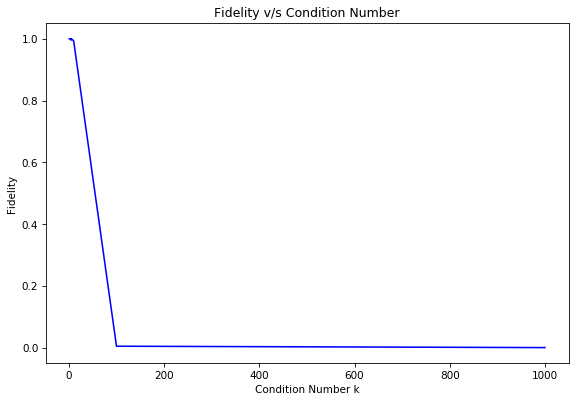

In [8]:
matlist=[np.array([[1,0],[0,1]]),
         np.array([[1,0.2],[0.2,1]]),
        np.array([[1,0],[0,0.5]]),
        np.array([[1.5,0],[0,0.5]]),
        np.array([[0.69,0.49],[0.49,0.92]]),
        np.array([[0.75,0.5],[0.5,0.75]]),
        np.array([[1,0],[0,0.1]]),
        np.array([[1,0],[0,0.01]]),
        np.array([[1,0],[0,0.001]])]

result=np.zeros((len(matlist),2))

for i in range(len(matlist)):
    vector = [0.707, 0.707]
    
    e,v=np.linalg.eig(matlist[i])
    k=max(e)/min(e)

    fid=get_hhl_fidelity(matlist[i],vector,k)
    
    result[i,0]=round(k,3)
    result[i,1]=round(fid,4)

print('Fidelity for different condition number - HHL:')
print(result)


fig = plt.figure(figsize=(9,6),dpi=75)
ax = plt.axes()

ax.plot(result[:,0], result[:,1],color='blue');
plt.title("Fidelity v/s Condition Number")
plt.xlabel("Condition Number k")
plt.ylabel("Fidelity");

plt.savefig('2_2Matrix.png')
plt.show()



Matrix:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Condition Number: 1.0
Solution:		 [0.707-0.j 0.707-0.j 0.707-0.j 0.707-0.j]
Classical Solution:	 [0.707 0.707 0.707 0.707]
Probability:		 0.020408
Fidelity:		 1.000000

Matrix:
 [[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  0.5]]
Condition Number: 2.0
Solution:		 [0.72721-0.j 0.72721-0.j 0.72721-0.j 1.28511-0.j]
Classical Solution:	 [0.707 0.707 0.707 1.414]
Probability:		 0.057857
Fidelity:		 0.996206

Matrix:
 [[1.    0.333 0.    0.   ]
 [0.333 1.    0.333 0.   ]
 [0.    0.333 1.    0.333]
 [0.    0.    0.333 1.   ]]
Condition Number: 3.3365634495764898
Solution:		 [0.5638 -0.j 0.39753-0.j 0.39753-0.j 0.5638 -0.j]
Classical Solution:	 [0.57851 0.38586 0.38586 0.57851]
Probability:		 0.036317
Fidelity:		 0.999329

Matrix:
 [[0.97 0.   0.   0.  ]
 [0.   0.81 0.   0.  ]
 [0.   0.   0.3  0.  ]
 [0.   0.   0.   0.13]]
Condition Number: 7.461538461538461
Solution:		 [0.7262 +0.j 0.883  +0.j 2.50939-0.j 5.01425+0

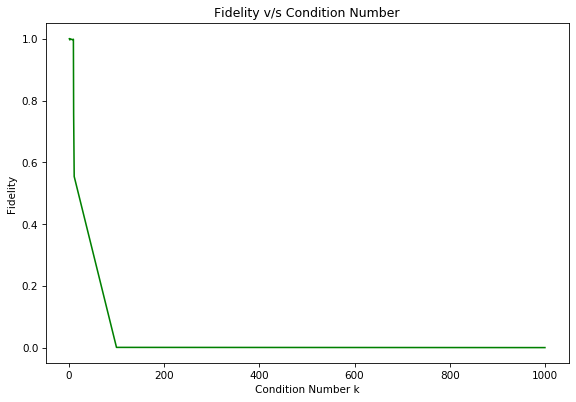

In [13]:
matlist=[np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]),
         np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0.5]]),
         np.array([[1,0.333,0,0],[0.333,1,0.333,0],[0,0.333,1,0.333],[0,0,0.333,1]]),
         np.array([[0.97,0,0,0],[0,0.81,0,0],[0,0,0.3,0],[0,0,0,0.13]]),
         np.array([[1,-0.5,0,0],[-0.5,1,-0.5,0],[0,-0.5,1,-0.5],[0,0,-0.5,1]]),
         np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0.1]]),
         np.array([[0.99,0.37,0.31,0],[0.37,0.32,0.15,0.15],[0.31,0.15,0.6,0.21],[0,0.15,0.21,0.73]]),
         np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0.01]]),
         np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0.001]])]

result=np.zeros((len(matlist),2))

for i in range(len(matlist)):
    vector = [0.707, 0.707, 0.707, 0.707]
    
    e,v=np.linalg.eig(matlist[i])
    k=max(e)/min(e)

    fid=get_hhl_fidelity(matlist[i],vector,k)
    
    result[i,0]=round(k,3)
    result[i,1]=round(fid,4)

print('Fidelity for different condition number - HHL:')
print(result)

fig = plt.figure(figsize=(9,6),dpi=75)
ax = plt.axes()

ax.plot(result[:,0], result[:,1],color='green');
plt.title("Fidelity v/s Condition Number")
plt.xlabel("Condition Number k")
plt.ylabel("Fidelity");

plt.savefig('2_2Matrix.png')
plt.show()


## Finite Difference Matrix Simulation

### Example 1 - 4*4 matrix 

In [17]:
matrix = np.array([[2, -1, 0, 0], [-1, 2, -1, 0], [0, -1,  2, -1],[0, 0, -1, 2]])
vector = [0.707, 0.707, 0.707, 0.707]

e,v=np.linalg.eig(matrix)

print('Matrix:\n',matrix)
print('Eigen Values:',e)
print('Condition Number:',max(e)/min(e))
#to find x using the HHL 

Matrix:
 [[ 2 -1  0  0]
 [-1  2 -1  0]
 [ 0 -1  2 -1]
 [ 0  0 -1  2]]
Eigen Values: [3.61803399 2.61803399 0.38196601 1.38196601]
Condition Number: 9.47213595499957


In [18]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 5, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)


circ=algo.construct_circuit(measurement=True)
#circ.draw(fold=-1)

In [19]:
result = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
print("Solution:\t\t", np.round(result['solution'], 5))

#print(result)

result_ref = NumPyLSsolver(matrix, vector).run()
print("Classical Solution:\t", np.round(result_ref['solution'], 5))

print("Probability:\t\t %f" % result['probability_result'])
fid=fidelity(result['solution'], result_ref['solution'])
print("Fidelity:\t\t %f\n" % fid)

Solution:		 [1.41389-0.j 2.11194-0.j 2.11194-0.j 1.41389-0.j]
Classical Solution:	 [1.414 2.121 2.121 1.414]
Probability:		 0.105431
Fidelity:		 0.999996

